In [164]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

sns.set_theme()

In [138]:
from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

In [139]:
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

In [140]:
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"

In [141]:
data = pd.read_csv(DATA_PATH + "credit_scoring_sample.csv", sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [6]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of the target:


SeriousDlqin2yrs
0    0.777511
1    0.222489
Name: count, dtype: float64

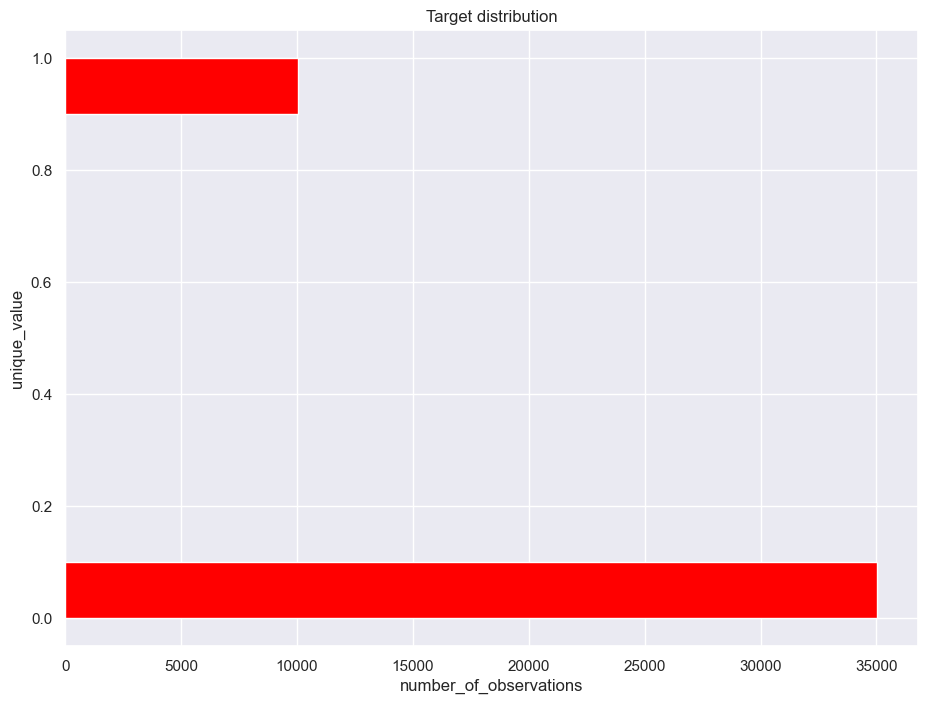

In [7]:
ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of the target:")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

In [142]:
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [143]:
table = fill_nan(data)

In [144]:
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

## Try Bootstrap which was somwere in teh conspects (i guess?)

In [245]:
np.random.seed(0)

In [246]:
def get_bootstrap_samples(data, n_samples):
    """Generate bootstrap samples using the bootstrap method."""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [247]:
def stat_intervals(stat, alpha):
    """Produce an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2.0, 100 * (1 - alpha / 2.0)])
    return boundaries

In [248]:
mean_interval = [
    np.mean(sample) for sample in \
    get_bootstrap_samples(table.loc[table.SeriousDlqin2yrs == 1, 'age'].values, 1000)
]


In [250]:
stat_intervals(mean_interval, 0.1)

array([45.71379414, 46.12700479])

### Logistic Regression

In [148]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [253]:
lr = LogisticRegression(random_state=5, class_weight="balanced")

In [254]:
parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}

In [255]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [256]:
search = GridSearchCV(lr, param_grid=parameters, scoring='roc_auc', n_jobs=-1, cv=skf)

In [193]:
roc_auc_search = search.best_score_

In [259]:
best_model = search.best_estimator_
best_model.C, search.cv_results_["std_test_score"][1]

(10, np.float64(0.0069488137327245875))

### Feature importance (** how ot use softmax funcion??? **)

In [260]:
lr = LogisticRegression(C=10, random_state=5, class_weight="balanced")
scaler = StandardScaler()
lr.fit(scaler.fit_transform(X), y)

LogisticRegression(C=10, class_weight='balanced', random_state=5)

In [261]:
pd.DataFrame({'feature_name': list(X),
              'coef': lr.coef_.ravel(), 
              'coef_abs': np.abs(lr.coef_.ravel())})\
    .sort_values('coef_abs', ascending=False)

,feature_name,coef,coef_abs
1,NumberOfTime30-59DaysPastDueNotWorse,3.276867,3.276867
3,NumberOfTimes90DaysLate,3.067259,3.067259
0,age,-0.436555,0.436555
5,MonthlyIncome,-0.203801,0.203801
6,NumberOfDependents,0.085393,0.085393
4,NumberOfTime60-89DaysPastDueNotWorse,0.076824,0.076824
2,DebtRatio,-0.041773,0.041773


In [158]:
from sklearn.inspection import permutation_importance

In [159]:
perm_importance = permutation_importance(best_model, X, y, n_repeats=30, random_state=42, n_jobs=-1)

In [160]:
pd.DataFrame({
    'Feature': X.columns,
    'Importance_Mean': perm_importance.importances_mean,
    'Importance_Std': perm_importance.importances_std
}).sort_values('Importance_Mean', ascending=False)

,Feature,Importance_Mean,Importance_Std
1,NumberOfTime30-59DaysPastDueNotWorse,0.065057,0.001120
3,NumberOfTimes90DaysLate,0.046087,0.000960
4,NumberOfTime60-89DaysPastDueNotWorse,0.015849,0.000575
0,age,0.002505,0.000886
5,MonthlyIncome,0.002332,0.000414
2,DebtRatio,0.000039,0.000083
6,NumberOfDependents,-0.000126,0.000960


In [267]:
## Softmax function
(np.exp(lr.coef_[0]) / np.sum(np.exp(lr.coef_[0])))[2] # call [0] from coef_ because it is of form [[., ., .,]]

np.float64(0.018245554281686695)

### 7.

In [196]:
search_unscaled = GridSearchCV(lr, param_grid=parameters, scoring='roc_auc', n_jobs=-1, cv=skf)

In [197]:
search_unscaled.fit(X, y)

/Users/nikolaj/miniconda3/envs/first_chapter/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nikolaj/miniconda3/envs/first_chapter/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=5),
             n_jobs=-1, param_grid={'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)},
             scoring='roc_auc')

In [280]:

lr1 = LogisticRegression(C=10, random_state=5, class_weight="balanced")
lr1.fit(X, y)

# pd.DataFrame(
#     {"feat": independent_columns_names, "coef": lr.coef_.flatten().tolist()}
# ).sort_values(by="coef", ascending=False)

/Users/nikolaj/miniconda3/envs/first_chapter/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10, class_weight='balanced', random_state=5)

In [281]:
np.exp(lr1.coef_[0][0] * 20)

np.float64(0.7400262231447657)

### Random Forest

In [202]:
from sklearn.ensemble import RandomForestClassifier

In [203]:
rf = RandomForestClassifier(
    n_estimators=100, n_jobs=-1, random_state=42, class_weight="balanced"
)

In [204]:
parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

In [205]:
search_forest = GridSearchCV(rf, parameters, scoring='roc_auc', n_jobs=-1, cv=skf)

In [207]:
search_forest.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15], 'max_features': [1, 2, 4],
                         'min_samples_leaf': [3, 5, 7, 9]},
             scoring='roc_auc')

In [209]:
search_forest.best_score_ - roc_auc_search

np.float64(0.04782182778559241)

In [286]:
best_forest = search_forest.best_estimator_
list(X)[np.argmin(best_forest.feature_importances_)]

'NumberOfDependents'

### Bagging

In [231]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

parameters = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    "estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100],
}

In [229]:
bag = BaggingClassifier(estimator=LogisticRegression(class_weight="balanced"),
                        n_estimators=100,
                        n_jobs=-1,
                        random_state=42)

search_bag = RandomizedSearchCV(bag, 
                                parameters, 
                                n_iter=20, 
                                cv=skf, 
                                scoring='roc_auc', 
                                random_state=1)

In [230]:
search_bag.fit(X, y)

/Users/nikolaj/miniconda3/envs/first_chapter/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nikolaj/miniconda3/envs/first_chapter/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
                   estimator=BaggingClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                            random_state=5),
                                               random_state=42),
                   n_iter=20,
                   param_distributions={'estimator__C': [0.0001, 0.001, 0.01, 1,
                                                         10, 100],
                                        'max_features': [2, 3, 4],
                                        'max_samples': [0.5, 0.7, 0.9]},
                   random_state=1, scoring='roc_auc')

In [233]:
search_bag.best_score_

np.float64(0.7979563721072724)